<a href="https://colab.research.google.com/github/aidanjjoyce/Part-III-Project-Double-Pendula/blob/main/Learning_Equations_of_Motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1 - Introduction**

# **Section 2 - Imports**

Imports for Lagrangian Neural Networks (LNNs) and for visualising results

In order for JAX to see the GPU you need to run this cell, restart the runtime, then run the next one.

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit
import random as rand

from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

Checking a GPU is being used

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


Mounts Google Drive for saving plots

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Section 3: Modelling Dynamical Systems**

Borrowed from Greydanus Lagrangian Neural Networks tutorial and following [Diego Assencio's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6), the Lagrangian of the double pendulum is 

$$
\begin{align}
L = & \frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 +
	\frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2
	\cos(\theta_1 - \theta_2)\nonumber\\[3pt]
     &+ (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2
\end{align}
$$

<img src="https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/double_pend_schema.png"> 

In [ ]:
# Calculates kinetic energy and potential energy for double pendulum
# then returns the lagrangian
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

We'll want to check our results against an analytical solution. We can use equations 19-22 and 28 from [Diego's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6):

\begin{align}
& \alpha_1(\theta_1,\theta_2) ~:=~ \displaystyle\frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2)\\
&\alpha_2(\theta_1,\theta_2) ~:=~ \frac{l_1}{l_2}\cos(\theta_1-\theta_2)\\
&\displaystyle f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
-\frac{l_2}{l_1}\left(\frac{m_2}{m_1+m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2)
- \frac{g}{l_1} \sin\theta_1 \\
&\displaystyle f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
\frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1-\theta_2) - \frac{g}{l_2} \sin\theta_2 \\
&g_1 := \displaystyle\frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
\quad\quad
g_2 := \displaystyle\frac{-\alpha_2 f_1 + f_2}{1 - \alpha_1\alpha_2}
\end{align}

Having defined these quantities, we can express the analytical dynamics of the system in matrix form:

$$
\displaystyle\frac{d}{dt}
\left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
=
\left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
\\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right)
$$

In [ ]:
# Returns array containing functions used to calculate
# derivatives of the coordinates
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state

  # Gives intermediate quantities of interest to dw/dt
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)

  # Gives g = dw/dt
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

# **Section 4: Obtaining Dynamics From Lagrangians**

We have written our Lagrangian and now we want to use it to obtain the dynamics of the system. Physicists would ordinarily try applying the Euler-Lagrange relationship in order to compute a set of analytical equations of motion. In this situation, though, our Lagrangian is a neural network. Trying to get an analytic solution from a neural network Lagrangian would be like trying to knit with a plate of spaghetti.

A better idea is to obtain the dynamics through numerical integration, and to do this we'll need an expression for $\ddot q$. Let's begin with the E-L constraint and try to solve for $\ddot q$.

$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$

**Implementation.** If you look closely at Equation 4, you may notice that it involves both the Hessian and the gradient of a neural network during the forward pass of the LNN. This is not a trivial operation, but modern automatic differentiation makes things surprisingly smooth. Written in JAX, Equation 4 is just a few lines of code
```
q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @
        (jax.grad(lagrangian, 0)(q, q_t)
          - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
```

Big props to Stephan Hoyer for figuring this out. In order to get the full dynamics, we also have to integrate the equation of motion (JAX makes this easy with `odeint`).

In [ ]:
# Given a lagrangian fn and the state of a system,
# returns an array containing velocity and acceleration coordinates
# which can then be integrated to predict dynamics
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2) 
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

# Given a lagrangian fn and the initial state of a system,
# integrates equation_of_motion to find the state of the system
def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

### Helper functions
Here are a few useful helper functions for obtaining dynamics of the system.

In [ ]:
# Returns the double pendulum dynamics from the equations of motion derived above
@partial(jax.jit, static_argnums=0, backend='cpu')
def solve_autograd(lagrangian, initial_state, times, **kwargs):
  L = partial(lagrangian, **kwargs)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
# Effectively just integrating up the correct equations of motion
@partial(jax.jit, static_argnums=0, backend='cpu')
def solve_analytical(f_analytical, initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

# **Section 5: Compare Autograd vs. Analytic solutions for the Double Pendulum**
Having rewritten the Euler-Lagrange equation so that we can use automatic differentiation to obtain the dynamics of the system, it's time to make sure that this approach matches the analytic solution. Here, we'll choose a random initial state and obtain dynamics via both "autograd" and "analytic" approaches. Then we'll slightly perturb the analytic solution to measure how sensitive it is to initial conditions. Taken together, these measurements should give us an approximate idea of whether our autograd-based approach is doing something reasonable.

In [ ]:
# choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [ ]:
# computes dynamics analytically for an initial state
# and an initial state pertubed by noise of different magnitudes
%time x_analytical = jax.device_get(solve_analytical(f_analytical, x0, t))
noise_coeff_1, noise_coeff_2 = 1e-10, 1e-11
x_perturbed_1 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_1 * noise, t))
x_perturbed_2 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_2 * noise, t))

CPU times: user 689 ms, sys: 22.6 ms, total: 712 ms
Wall time: 693 ms


In [ ]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(lagrangian, x0, t, m1=1, m2=1, l1=1, l2=1, g=10))

CPU times: user 2.06 s, sys: 11.9 ms, total: 2.07 s
Wall time: 2.04 s


### Plot a comparison

This code is simply showing that using the method of obtaining the dynamics from the Lagrangian using the integrator created above works as well as directly integrating the known equations of motion

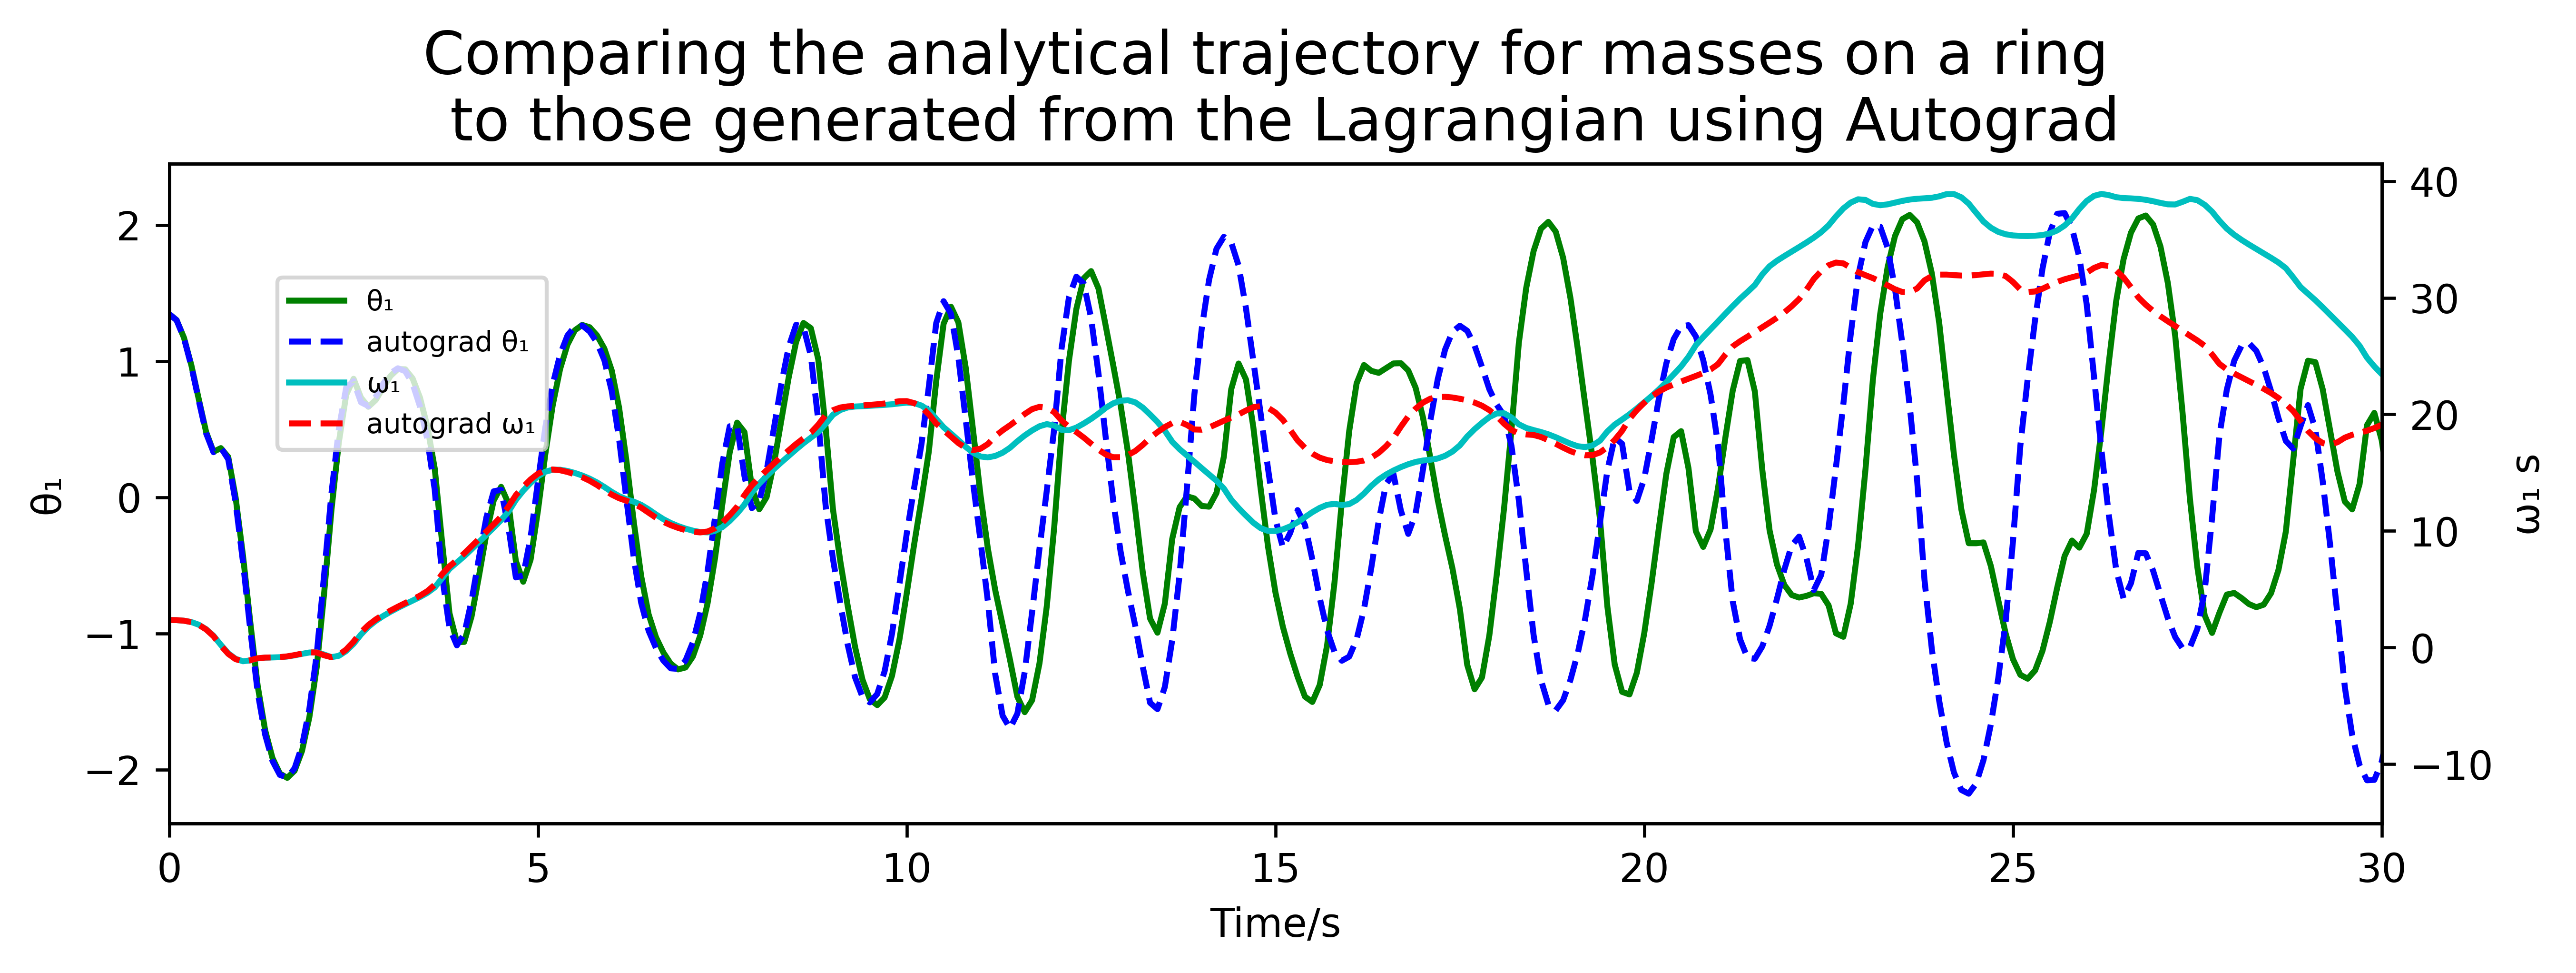

In [ ]:
fig, ax1 = plt.subplots(figsize=[10,3], dpi=600)

plt.title("Comparing the analytical trajectory for masses on a ring \n to those generated from the Lagrangian using Autograd", fontsize=15)
plt.xlim(0,30)
ax1.set_xlabel("Time/s", fontsize=10) 
ax1.set_ylabel("\u03B8\u2081", fontsize=10)
ax1.plot(t, x_analytical[:, 0], 'g-', label='\u03B8\u2081')
ax1.plot(t, x_autograd[:, 0], 'b--', label='autograd \u03B8\u2081')

ax2 = ax1.twinx()

ax2.set_ylabel("\u03C9\u2081 s", fontsize=10)
ax2.plot(t, x_analytical[:, 1], 'c-', label='\u03C9\u2081')
ax2.plot(t, x_autograd[:, 1], 'r--', label='autograd \u03C9\u2081')

fig.legend(fontsize=7, loc="upper left", borderaxespad=10)

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
fig.savefig(f"{images_dir}/AutogradForDoublePendulums.png", bbox_inches='tight')


fig.show()

# Section 6: Generate Training Data

Let's generate some training data by using the analytical method to sample dynamics.

In [ ]:
def generate_training_data(time_step, N, x0):
  
  analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

  t = np.arange(N, dtype=np.float32)
  x_train = jax.device_get(solve_analytical(f_analytical, x0, t)) 
  xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) 
  y_train = jax.device_get(analytical_step(x_train)) 

  t_test = np.arange(N, 2*N, dtype=np.float32) 
  x_test = jax.device_get(solve_analytical(f_analytical, x0, t_test)) 
  xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) 
  y_test = jax.device_get(analytical_step(x_test)) 

  return [x_train, xt_train, y_train, x_test, xt_test, y_test]

# Section 7: Testing Lagrangian Neural Networks

In [ ]:
training_data = generate_training_data(0.01, 1500, np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32))


x_train = training_data[0]
xt_train = training_data[1]
y_train = training_data[2]
x_test = training_data[3]
xt_test = training_data[4]
y_test = training_data[5]

# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

  # build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
num_batches = 1500
batch_size = 100
test_every = 50

train_losses = []
test_losses = []

# adam w learn rate decay 
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                        [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):

  # once per batch calculates train/test losses and prints 
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  
  # performs optimisation
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

KeyboardInterrupt: ignored

In [ ]:
losses = [train_losses, test_losses]

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.scatter(np.arange(len(losses[0])), losses[0], label='Train loss', s=1)
plt.scatter(np.arange(len(losses[1])), losses[1], label='Test loss', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend()

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/FirstDoublePendulumExperiment.png", bbox_inches='tight')

plt.show

Plots to show how well LNN predicts dynamics vs a perturbed system

In [ ]:
# make a meshgrid of possible angles
angle_range = -np.pi + 2 * np.pi * np.arange(100)/100
x_scanned = np.stack(np.meshgrid(angle_range, angle_range, [0.0], [0.0], indexing='ij'), axis=-1).reshape(-1, 4)

%time xt_actual = jax.vmap(f_analytical)(x_scanned) # actual time derivatives

%time xt_predicted = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_scanned) # predicted time derivatives

import xarray
dataarray = xarray.DataArray(np.stack([xt_actual.reshape(100, 100, 4),
                                       xt_predicted.reshape(100, 100, 4)]),
                             dims=['model', '$\theta_{1}$', '$\theta_{2}$', 'time_derivative'],
                             coords={'model': ['actual', 'predicted'], '$\theta_{1}$': angle_range, '$\theta_{2}$': angle_range})

In [ ]:
dataarray.isel(time_derivative=2).plot.contourf(levels=31, col='model', x='theta1', y='$\theta_{2}$', vmin=-10, vmax=10)
print("Colorscale is $\dot{\theta_{1}}$")

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/DoublePendulumPredictedt1Accelerations.png", bbox_inches='tight')

plt.show()

In [ ]:
dataarray.isel(time_derivative=3).plot.contourf(levels=31, col='model', x='$\theta_{1}$', y='$\theta_{2}$', vmin=-10, vmax=10)
print("Colorscale is $\dot{theta_{2}}$")

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/DoublePendulumPredictedt2Accelerations.png", bbox_inches='tight')

plt.show()

# Section 8: Investigating The Effect Of Different Initial Conditions on Lagrangian Neural Networks

In [ ]:
def simple_LNN(training_data, num_batches):

  x_train = training_data[0]
  xt_train = training_data[1]
  y_train = training_data[2]
  x_test = training_data[3]
  xt_test = training_data[4]
  y_test = training_data[5]

  # replace the lagrangian with a parameteric model
  def learned_lagrangian(params):
    def lagrangian(q, q_t):
      assert q.shape == (2,)
      state = normalize_dp(jnp.concatenate([q, q_t]))
      return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
    return lagrangian

  # define the loss of the model (MSE between predicted q, \dot q and targets)
  @jax.jit
  def loss(params, batch, time_step=None):
    state, targets = batch
    if time_step is not None:
      f = partial(equation_of_motion, learned_lagrangian(params))
      preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
    else:
      preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
    return jnp.mean((preds - targets) ** 2)

  @jax.jit
  def update_timestep(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

  @jax.jit
  def update_derivative(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

    # build a neural network model
  init_random_params, nn_forward_fn = stax.serial(
      stax.Dense(128),
      stax.Softplus,
      stax.Dense(128),
      stax.Softplus,
      stax.Dense(1),
  )

  x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
  y_train = jax.device_put(y_train)

  x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
  y_test = jax.device_put(y_test)

  rng = jax.random.PRNGKey(0)
  _, init_params = init_random_params(rng, (-1, 4))

  # numbers in comments denote stephan's settings
  batch_size = 100
  test_every = 50

  train_losses = []
  test_losses = []

  # adam w learn rate decay 
  opt_init, opt_update, get_params = optimizers.adam(
      lambda t: jnp.select([t < batch_size*(num_batches//3),
                            t < batch_size*(2*num_batches//3),
                            t > batch_size*(2*num_batches//3)],
                          [1e-3, 3e-4, 1e-4]))
  opt_state = opt_init(init_params)

  for iteration in range(batch_size*num_batches + 1):

    # once per batch calculates train/test losses and prints 
    if iteration % batch_size == 0:
      params = get_params(opt_state)
      train_loss = loss(params, (x_train, xt_train))
      train_losses.append(train_loss)
      test_loss = loss(params, (x_test, xt_test))
      test_losses.append(test_loss)
      if iteration % (batch_size*test_every) == 0:
        print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
    
    # performs optimisation
    opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

  params = get_params(opt_state)

  return [train_losses, test_losses, params]

In [ ]:
x1 = np.array([np.pi/2, 0, 0, 0])
training_data_1 = generate_training_data(0.01, 1500, x1)
print(x1)
print(training_data_1)
losses_1 = simple_LNN(training_data_1, 1500)

[1.57079633 0.         0.         0.        ]
[array([[ 1.5707964 ,  0.        ,  0.        ,  0.        ],
       [-0.8847595 , -0.46788907,  2.0813124 , -6.108255  ],
       [ 0.8296784 , -1.216787  ,  0.04558157,  3.716167  ],
       ...,
       [-0.33862305, -1.62213   , -0.17954679, -3.9863844 ],
       [ 0.2318114 , -0.8049485 , -1.3595885 ,  6.0690565 ],
       [ 0.5692744 ,  1.9370215 ,  0.21221359, -2.5535903 ]],
      dtype=float32), array([[ 0.0000000e+00,  0.0000000e+00, -9.8000002e+00, -4.2837161e-07],
       [ 2.0813124e+00, -6.1082549e+00,  2.3914677e+01, -1.9200783e+01],
       [ 4.5581568e-02,  3.7161670e+00, -1.2582106e+01,  3.4323871e+00],
       ...,
       [-1.7954679e-01, -3.9863844e+00, -5.9962344e+00,  1.1517062e+01],
       [-1.3595885e+00,  6.0690565e+00, -2.3328707e+01,  2.0529478e+01],
       [ 2.1221359e-01, -2.5535903e+00, -1.1860521e+00, -8.9550533e+00]],
      dtype=float32), array([[ 1.5703064e+00,  1.2002451e-07, -9.8000012e-02,  4.8014073e-05],
      

In [ ]:
x2 = np.array([np.pi/2, 0, 0.1, 0.1])
training_data_2 = generate_training_data(0.01, 1500, x2)
print(x2)
print(training_data_2)
losses_2 = simple_LNN(training_data_2, 1500)

[1.57079633 0.         0.1        0.1       ]
[array([[ 1.5707964 ,  0.        ,  0.1       ,  0.1       ],
       [-0.8688686 , -0.4378397 ,  2.0017967 , -6.1529236 ],
       [ 0.80811024, -1.3584075 ,  0.3664662 ,  3.5845597 ],
       ...,
       [-0.4226556 ,  1.3931643 , -0.7016868 ,  4.1519275 ],
       [ 0.06139305,  2.6796417 , -0.71197903, -1.7870902 ],
       [ 0.17961283, -1.833875  , -2.5799367 , -2.4484775 ]],
      dtype=float32), array([[ 1.00000001e-01,  1.00000001e-01, -9.80500031e+00,
         9.99957230e-03],
       [ 2.00179672e+00, -6.15292358e+00,  2.42900105e+01,
        -1.95875435e+01],
       [ 3.66466194e-01,  3.58455968e+00, -1.14935970e+01,
         3.24183297e+00],
       ...,
       [-7.01686800e-01,  4.15192747e+00,  1.14918585e+01,
        -7.33576822e+00],
       [-7.11979032e-01, -1.78709018e+00, -2.88773990e+00,
        -7.12238359e+00],
       [-2.57993674e+00, -2.44847751e+00, -1.25989997e+00,
         1.49375563e+01]], dtype=float32), array([[ 1.57

In [ ]:
x3 = np.array([np.pi/10, np.pi/5, 0, 0])
training_data_3 = generate_training_data(0.01, 1500, x3)
print(x3)
print(training_data_3)
losses_3 = simple_LNN(training_data_3, 1500)

[0.31415927 0.62831853 0.         0.        ]
[array([[ 0.31415927,  0.62831855,  0.        ,  0.        ],
       [-0.32765925, -0.29811478, -0.83444935, -0.5853945 ],
       [-0.02805585,  0.06176848,  0.47579816,  1.8457851 ],
       ...,
       [-0.01033816, -0.00958816, -0.40872452, -1.9346153 ],
       [-0.29149428, -0.31205386,  1.0187839 ,  0.4036547 ],
       [ 0.3215696 ,  0.6162221 ,  0.12205376, -0.29197723]],
      dtype=float32), array([[ 0.        ,  0.        , -0.5279519 , -5.2581835 ],
       [-0.83444935, -0.5853945 ,  3.4583015 , -0.59891796],
       [ 0.47579816,  1.8457851 ,  1.4663694 , -2.0857112 ],
       ...,
       [-0.40872452, -1.9346153 ,  0.11159418, -0.01775693],
       [ 1.0187839 ,  0.4036547 ,  2.5988398 ,  0.4317838 ],
       [ 0.12205376, -0.29197723, -0.6879139 , -5.0100303 ]],
      dtype=float32), array([[ 0.31413287,  0.62805563, -0.00528037, -0.05257398],
       [-0.33582917, -0.3039994 , -0.79937595, -0.5915969 ],
       [-0.02322251,  0.08011

In [ ]:
x4 = np.array([3*np.pi/2, np.pi/2, 0, 0])
training_data_4 = generate_training_data(0.01, 1500, x4)
print(x4)
print(training_data_4)
losses_4 = simple_LNN(training_data_4, 1500)

[4.71238898 1.57079633 0.         0.        ]
[array([[  4.712389  ,   1.5707964 ,   0.        ,   0.        ],
       [  7.583941  ,  -1.3699722 ,   0.3076681 ,  -3.5011342 ],
       [  6.4730115 ,  -6.8295918 ,   3.5520291 ,  -8.709539  ],
       ...,
       [  7.392085  , 239.44864   ,   3.414989  ,  -7.783777  ],
       [  4.314898  , 239.16693   ,  -0.24066974,   2.1797624 ],
       [  7.746187  , 237.88214   ,   0.8230769 ,  -3.7284281 ]],
      dtype=float32), array([[  0.        ,   0.        ,   9.8       ,   0.        ],
       [  0.3076681 ,  -3.5011342 , -13.148335  ,  -2.071494  ],
       [  3.5520291 ,  -8.709539  , -44.5837    ,  46.601242  ],
       ...,
       [  3.414989  ,  -7.783777  , -35.12524   ,  30.603113  ],
       [ -0.24066974,   2.1797624 ,  12.521341  ,   5.1021123 ],
       [  0.8230769 ,  -3.7284281 , -15.754879  ,  -2.947806  ]],
      dtype=float32), array([[ 4.7128792e+00,  1.5707964e+00,  9.7999983e-02, -4.1325876e-08],
       [ 7.5863619e+00, -1.405

In [ ]:
x5 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0])
training_data_5 = generate_training_data(0.01, 1500, x5)
print(x5)
print(training_data_5)
losses_5 = simple_LNN(training_data_5, 1500)

[1.34639685 2.35619449 0.         0.        ]
[array([[  1.3463968 ,   2.3561945 ,   0.        ,   0.        ],
       [ -0.42738846,  -1.1811663 ,  -4.6661735 ,  -0.63316816],
       [ -1.2464706 ,  -0.41254658,   4.4142275 ,  -0.6399314 ],
       ...,
       [ -0.51173127, 299.2767    ,   3.5176985 ,   4.5041037 ],
       [  2.0330842 , 302.74152   ,   1.6238078 ,  -2.8264499 ],
       [ -1.3741199 , 301.95685   ,  -4.464466  ,  -2.6130226 ]],
      dtype=float32), array([[  0.        ,   0.        ,  -8.982129  ,  -2.1508672 ],
       [ -4.6661735 ,  -0.63316816,  -6.554622  ,  28.746038  ],
       [  4.4142275 ,  -0.6399314 ,  16.750912  , -21.75733   ],
       ...,
       [  3.5176985 ,   4.5041037 ,  -2.9196603 ,  18.563059  ],
       [  1.6238078 ,  -2.8264499 , -12.105825  ,   0.7717132 ],
       [ -4.464466  ,  -2.6130226 ,  11.206209  , -21.27603   ]],
      dtype=float32), array([[ 1.3459477e+00,  2.3560867e+00, -8.9807421e-02, -2.1549953e-02],
       [-4.7437453e-01, -1.186

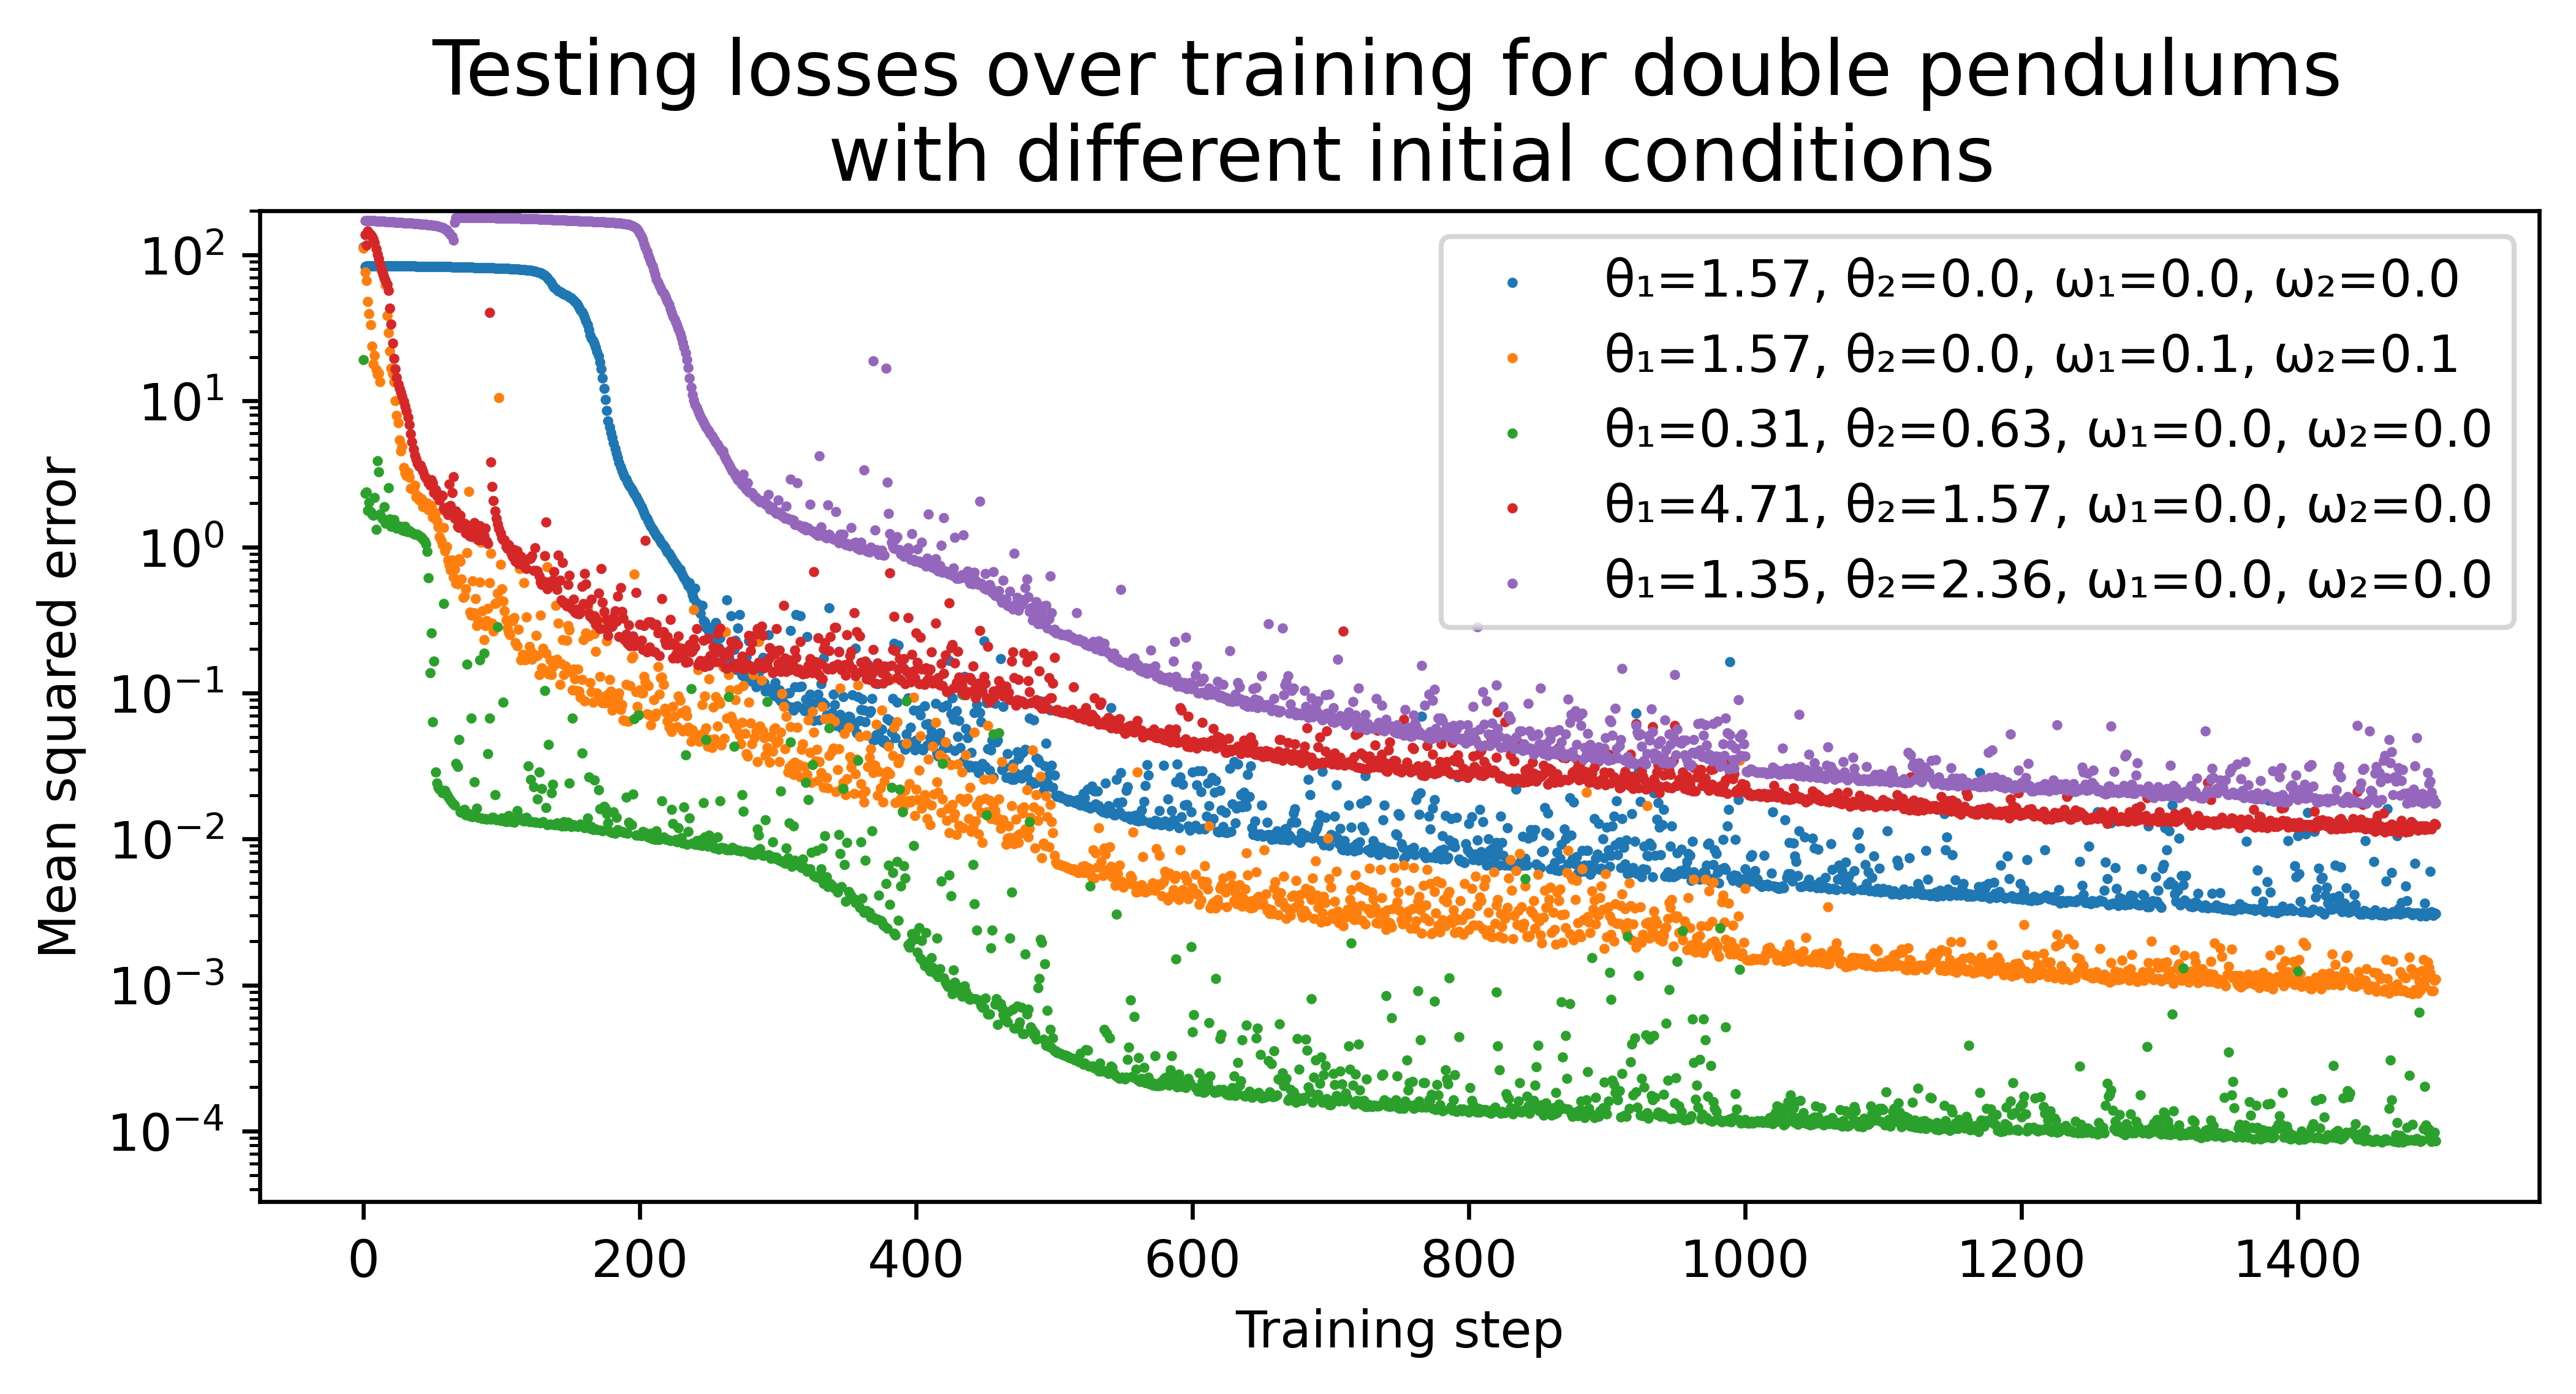

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=600)
plt.style.use('default')
plt.scatter(np.arange(len(losses_1[1])), losses_1[1], label=f'\u03B8\u2081={round(x1[0],2)}, \u03B8\u2082={round(x1[1],2)}, \u03C9\u2081={round(x1[2],2)}, \u03C9\u2082={round(x1[3],2)}', s=1)
plt.scatter(np.arange(len(losses_2[1])), losses_2[1], label=f'\u03B8\u2081={round(x2[0],2)}, \u03B8\u2082={round(x2[1],2)}, \u03C9\u2081={round(x2[2],2)}, \u03C9\u2082={round(x2[3],2)}', s=1)
plt.scatter(np.arange(len(losses_3[1])), losses_3[1], label=f'\u03B8\u2081={round(x3[0],2)}, \u03B8\u2082={round(x3[1],2)}, \u03C9\u2081={round(x3[2],2)}, \u03C9\u2082={round(x3[3],2)}', s=1)
plt.scatter(np.arange(len(losses_4[1])), losses_4[1], label=f'\u03B8\u2081={round(x4[0],2)}, \u03B8\u2082={round(x4[1],2)}, \u03C9\u2081={round(x4[2],2)}, \u03C9\u2082={round(x4[3],2)}', s=1)
plt.scatter(np.arange(len(losses_5[1])), losses_5[1], label=f'\u03B8\u2081={round(x5[0],2)}, \u03B8\u2082={round(x5[1],2)}, \u03C9\u2081={round(x5[2],2)}, \u03C9\u2082={round(x5[3],2)}', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title("Testing losses over training for double pendulums \n with different initial conditions", fontsize=15)
plt.xlabel("Training step") ; plt.ylabel("Mean squared error")
plt.legend(fontsize=10)

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/doublependula_comparing_conditions.png", bbox_inches='tight')

plt.show()

#Section 9: Investigating The Effect Of Adding Noise To Lagrangian Neural Networks

Generating data sets with different degrees of random noise applied

In [ ]:
time_step = 0.01
N = 1500
# Applies one step of Runge-Kutte integration to the analytically derived eoms
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
# Only trains and tests on one set of initial conditions?!
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.arange(N, dtype=np.float32) # time steps 0 to N

# Idea is to train on the first time interval and then observe on the second
noise2 = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N

In [ ]:
%time dp_x_train = jax.device_get(solve_analytical(f_analytical, x0, t)) # dynamics for first N time steps
%time dp_xt_train = jax.device_get(jax.vmap(f_analytical)(dp_x_train)) # time derivatives of each state
%time dp_y_train = jax.device_get(analytical_step(dp_x_train)) # analytical next step

%time dp_x_test = jax.device_get(solve_analytical(f_analytical, x0, t_test)) # dynamics for next N time steps
%time dp_xt_test = jax.device_get(jax.vmap(f_analytical)(dp_x_test)) # time derivatives of each state
%time dp_y_test = jax.device_get(analytical_step(dp_x_test)) # analytical next step

In [ ]:
noise_coeff_1 = 10e-8

%time dp_x_train_noisy1 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_1 * noise, t)) # dynamics for first N time steps
%time dp_xt_train_noisy1 = jax.device_get(jax.vmap(f_analytical)(dp_x_train_noisy1)) # time derivatives of each state
%time dp_y_train_noisy1 = jax.device_get(analytical_step(dp_x_train_noisy1)) # analytical next step

%time dp_x_test_noisy1 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_1 * noise2, t_test)) # dynamics for next N time steps
%time dp_xt_test_noisy1 = jax.device_get(jax.vmap(f_analytical)(dp_x_test_noisy1)) # time derivatives of each state
%time dp_y_test_noisy1 = jax.device_get(analytical_step(dp_x_test_noisy1)) # analytical next step

In [ ]:
noise_coeff_2 = 10e-4

%time dp_x_train_noisy2 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_2 * noise, t)) # dynamics for first N time steps
%time dp_xt_train_noisy2 = jax.device_get(jax.vmap(f_analytical)(dp_x_train_noisy2)) # time derivatives of each state
%time dp_y_train_noisy2 = jax.device_get(analytical_step(dp_x_train_noisy2)) # analytical next step

%time dp_x_test_noisy2 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_2 * noise2, t_test)) # dynamics for next N time steps
%time dp_xt_test_noisy2 = jax.device_get(jax.vmap(f_analytical)(dp_x_test_noisy2)) # time derivatives of each state
%time dp_y_test_noisy2 = jax.device_get(analytical_step(dp_x_test_noisy2)) # analytical next step

In [ ]:
noise_coeff_3 = 10e-6

%time dp_x_train_noisy3 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_3 * noise, t)) # dynamics for first N time steps
%time dp_xt_train_noisy3 = jax.device_get(jax.vmap(f_analytical)(dp_x_train_noisy3)) # time derivatives of each state
%time dp_y_train_noisy3 = jax.device_get(analytical_step(dp_x_train_noisy3)) # analytical next step

%time dp_x_test_noisy3 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_3 * noise2, t_test)) # dynamics for next N time steps
%time dp_xt_test_noisy3 = jax.device_get(jax.vmap(f_analytical)(dp_x_test_noisy3)) # time derivatives of each state
%time dp_y_test_noisy3 = jax.device_get(analytical_step(dp_x_test_noisy3)) # analytical next step

In [ ]:
noise_coeff_4 = 10e-10

%time dp_x_train_noisy4 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_4 * noise, t)) # dynamics for first N time steps
%time dp_xt_train_noisy4 = jax.device_get(jax.vmap(f_analytical)(dp_x_train_noisy4)) # time derivatives of each state
%time dp_y_train_noisy4 = jax.device_get(analytical_step(dp_x_train_noisy4)) # analytical next step

%time dp_x_test_noisy4 = jax.device_get(solve_analytical(f_analytical, x0 + noise_coeff_4 * noise2, t_test)) # dynamics for next N time steps
%time dp_xt_test_noisy4 = jax.device_get(jax.vmap(f_analytical)(dp_x_test_noisy4)) # time derivatives of each state
%time dp_y_test_noisy4 = jax.device_get(analytical_step(dp_x_test_noisy4)) # analytical next step

Defines functions used in a LNN

In [ ]:
def simple_LNN(x_train, xt_train, y_train, x_test, xt_test, y_test):

  # replace the lagrangian with a parameteric model
  def learned_lagrangian(params):
    def lagrangian(q, q_t):
      assert q.shape == (2,)
      state = normalize_dp(jnp.concatenate([q, q_t]))
      return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
    return lagrangian

  # define the loss of the model (MSE between predicted q, \dot q and targets)
  @jax.jit
  def loss(params, batch, time_step=None):
    state, targets = batch
    if time_step is not None:
      f = partial(equation_of_motion, learned_lagrangian(params))
      preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
    else:
      preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
    return jnp.mean((preds - targets) ** 2)

  @jax.jit
  def update_timestep(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

  @jax.jit
  def update_derivative(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

    # build a neural network model
  init_random_params, nn_forward_fn = stax.serial(
      stax.Dense(128),
      stax.Softplus,
      stax.Dense(128),
      stax.Softplus,
      stax.Dense(1),
  )

  x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
  y_train = jax.device_put(y_train)

  x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
  y_test = jax.device_put(y_test)

  rng = jax.random.PRNGKey(0)
  _, init_params = init_random_params(rng, (-1, 4))

  # numbers in comments denote stephan's settings
  batch_size = 100
  test_every = 50
  num_batches = 1500

  train_losses = []
  test_losses = []

  # adam w learn rate decay 
  opt_init, opt_update, get_params = optimizers.adam(
      lambda t: jnp.select([t < batch_size*(num_batches//3),
                            t < batch_size*(2*num_batches//3),
                            t > batch_size*(2*num_batches//3)],
                          [1e-3, 3e-4, 1e-4]))
  opt_state = opt_init(init_params)

  for iteration in range(batch_size*num_batches + 1):

    # once per batch calculates train/test losses and prints 
    if iteration % batch_size == 0:
      params = get_params(opt_state)
      train_loss = loss(params, (x_train, xt_train))
      train_losses.append(train_loss)
      test_loss = loss(params, (x_test, xt_test))
      test_losses.append(test_loss)
      if iteration % (batch_size*test_every) == 0:
        print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
    
    # performs optimisation
    opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

  params = get_params(opt_state)

  return [train_losses, test_losses]

Runs a LNN with the noiseless data and plots the losses

In [ ]:
noiseless_losses = simple_LNN(dp_x_train, dp_xt_train, dp_y_train, dp_x_test, dp_xt_test, dp_y_test)

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.style.use('default')
plt.scatter(np.arange(len(noiseless_losses[0])), noiseless_losses[0], label='Train loss', s=1)
plt.scatter(np.arange(len(noiseless_losses[1])), noiseless_losses[1], label='Test loss', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training for a noiseless double pendulum')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend()

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/NOISE_dp_noiseless.png", bbox_inches='tight')

plt.show()

In [ ]:
noisy1_losses = simple_LNN(dp_x_train_noisy1, dp_xt_train_noisy1, dp_y_train_noisy1, dp_x_test_noisy1, dp_xt_test_noisy1, dp_y_test_noisy1)

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.style.use('default')
plt.scatter(np.arange(len(noisy1_losses[0])), noisy1_losses[0], label='Train loss', s=1)
plt.scatter(np.arange(len(noisy1_losses[1])), noisy1_losses[1], label='Test loss', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training for a double pendulum with 10e-8 noise added')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() 

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/NOISE_dp_10e-8_noise.png", bbox_inches='tight')

plt.show()

In [ ]:
noisy2_losses = simple_LNN(dp_x_train_noisy2, dp_xt_train_noisy2, dp_y_train_noisy2, dp_x_test_noisy2, dp_xt_test_noisy2, dp_y_test_noisy2)

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.style.use('default')
plt.scatter(np.arange(len(noisy2_losses[0])), noisy2_losses[0], label='Train loss', s=1)
plt.scatter(np.arange(len(noisy2_losses[1])), noisy2_losses[1], label='Test loss', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training for a double pendulum with 10e-4 noise added')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() 

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/NOISE_dp_10e-4_noise.png", bbox_inches='tight')

plt.show()

In [ ]:
noisy3_losses = simple_LNN(dp_x_train_noisy3, dp_xt_train_noisy3, dp_y_train_noisy3, dp_x_test_noisy3, dp_xt_test_noisy3, dp_y_test_noisy3)


In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.style.use('default')
plt.scatter(np.arange(len(noisy2_losses[0])), noisy3_losses[0], label='Train loss', s=1)
plt.scatter(np.arange(len(noisy2_losses[1])), noisy3_losses[1], label='Test loss', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training for a double pendulum with 10e-6 noise added')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend()

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/NOISE_dp_10e-6_noise.png", bbox_inches='tight')

plt.show()

In [ ]:
noisy4_losses = simple_LNN(dp_x_train_noisy4, dp_xt_train_noisy4, dp_y_train_noisy4, dp_x_test_noisy4, dp_xt_test_noisy4, dp_y_test_noisy4)

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.style.use('default')
plt.scatter(np.arange(len(noisy4_losses[0])), noisy4_losses[0], label='Train loss', s=1)
plt.scatter(np.arange(len(noisy4_losses[1])), noisy4_losses[1], label='Test loss', s=1)
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training for a double pendulum with 10e-10 noise added')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend()

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/NOISE_dp_10e-10_noise.png", bbox_inches='tight')

plt.show()

Comparing LNNs with different amounts of noise added to data

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.scatter(np.arange(len(noiseless_losses[0])), noiseless_losses[1], label='Noiseless testing loss', s=1)
plt.scatter(np.arange(len(noisy2_losses[0])), noisy2_losses[1], label='Testing loss with 10e-4 random noise added', s=1)
plt.scatter(np.arange(len(noisy3_losses[0])), noisy3_losses[1], label='Testing loss with 10e-6 random noise added', s=1)
plt.scatter(np.arange(len(noisy1_losses[0])), noisy1_losses[1], label='Testing loss with 10e-8 random noise added', s=1)
plt.scatter(np.arange(len(noisy4_losses[0])), noisy4_losses[1], label='Testing loss with 10e-10 random noise added', s=1)
plt.yscale('log')
plt.ylim(None, 300)
plt.title('Comparing test losses over training for LNNs with differing noise added')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend(loc=3, prop={'size': 6})

images_dir = '/content/gdrive/My Drive/University/III/Research Project'
plt.savefig(f"{images_dir}/NOISE_comparing_LNNs.png", bbox_inches='tight')

plt.show()